In [1]:
import numpy as np
import matplotlib.pyplot as plt
import model_base as mb
from experiments import get_null_ff_input_arrays

In [26]:
# define parameter dictionaries
N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)

# LH predictive coding params:
w_mean_update = dict(EP=2, DE=0.5, DS=0.5, PE=1.2, PP=1, PS=0.3, PV=0.3, SE=1, SV=0.6, VE=1, VS=0.7)
w_mean_update = dict(EP=2, DE=0., DS=1, PE=1.2, PP=0.4, PS=0.3, PV=0.15, SE=1, SV=0.5, VE=1, VS=1)  # these work!

w_mean.update(w_mean_update)

# w_mean.update(dict(VE=0))

# instantiate model
model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=False, flag_with_NDNF=False, flag_with_VIP=True, flag_with_PV=True)

In [2]:
## default parameters without VIP

# define parameter dictionaries
N_cells, w_mean, conn_prob, bg_inputs, taus = mb.get_default_params(flag_mean_pop=True)
w_mean.update(dict(DS=1.2, SE=0, PE=0, NS=1.5, PN=0))


# instantiate model
model = mb.NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=1, flag_w_hetero=False, flag_pre_inh=True, flag_with_NDNF=True,
                        flag_with_VIP=False, flag_with_PV=True)

# initial rates
rN0 = 1.9
rS0 = 1
rP0 = 1
rV0 = 0
rE0 = 1
rD0 = 0
p0 = 0.01

In [3]:
w_mean['DN']

0.4

In [4]:
def slice_dict(dic, ts, te):

    dic_new = dict()
    for k in dic.keys():
        dic_new[k] = dic[k][ts:te]

    return dic_new

In [5]:
# simulation parameters
dur_tot = 7000  # ms
dt = 1  # ms
t = np.arange(0, dur_tot, dt)
nt = len(t)

# construct input: fully prediced, overpredicted, underpredicted
amp = 1
fp_s, fp_e = 1000, 2000
op_s, op_e = 3000, 4000
up_s, up_e = 5000, 6000

sensory = np.zeros(nt)
sensory[fp_s:fp_e] = amp
sensory[up_s:up_e] = amp

prediction = np.zeros(nt)
prediction[fp_s:fp_e] = amp
prediction[op_s:op_e] = amp

In [6]:
# set input of cells
xFF = get_null_ff_input_arrays(nt, N_cells)
xFF['E'] = np.tile(sensory, [N_cells['E'], 1]).T
xFF['D'] = np.tile(prediction, [N_cells['D'], 1]).T
xFF['P'] = np.tile(sensory, [N_cells['P'], 1]).T
xFF['S'] = np.tile(sensory, [N_cells['S'], 1]).T
xFF['V'] = np.tile(prediction, [N_cells['V'], 1]).T
xFF['N'] = np.tile(prediction, [N_cells['N'], 1]).T


In [7]:
# run network, simulate 3 conditions separately to void long-lasting effects
dur = 3000
buffer = 1000
xFFfp = slice_dict(xFF, fp_s-buffer, fp_e+buffer)
xFFop = slice_dict(xFF, op_s-buffer, op_e+buffer)
xFFup = slice_dict(xFF, up_s-buffer, up_e+buffer)
# t, rE, rD, rS, rN, rP, rV, p, cGABA, other = model.run(dur, xFF, dt=dt, rE0=1, rP0=4, rS0=4, rV0=4, rD0=0, p0=0.5, calc_bg_input=True)
t, rEfp, rDfp, rSfp, rNfp, rPfp, rVfp, pfp, cGABAfp, other = model.run(dur, xFFfp, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)
t, rEop, rDop, rSop, rNop, rPop, rVop, pop, cGABAop, other = model.run(dur, xFFop, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)
t, rEup, rDup, rSup, rNup, rPup, rVup, pup, cGABAup, other = model.run(dur, xFFup, dt=dt, rE0=rE0, rP0=rP0, rS0=rS0, rV0=rV0, rN0=rN0, rD0=rD0, p0=p0, calc_bg_input=True)

print(model.Xbg)
t = t/1000

{'E': 1.5, 'D': 1.96, 'N': 3.78, 'S': 1, 'P': 1.9000000000000001, 'V': 0}


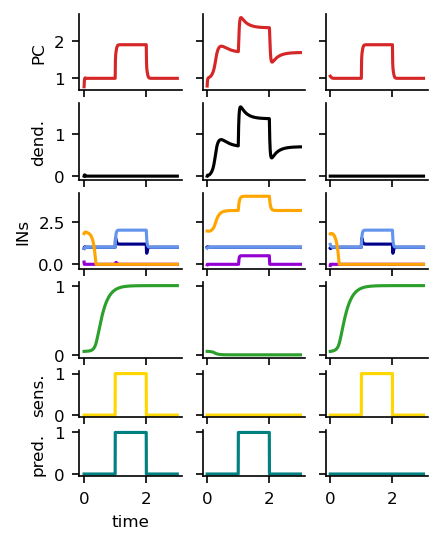

In [8]:
fig, ax = plt.subplots(6, 3, dpi=150, figsize=(3, 4), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.6, 0.6]}, sharey='row')

for i, cond in enumerate(['fp', 'op', 'up']):
    ax[0, i].plot(t, eval('rE'+cond), c='C3')
    ax[1, i].plot(t, eval('rD'+cond), c='k')
    ax[2, i].plot(t, eval('rP'+cond), c='darkblue')
    ax[2, i].plot(t, eval('rV'+cond), c='darkviolet')
    ax[2, i].plot(t, eval('rS'+cond), c='cornflowerblue')
    ax[2, i].plot(t, eval('rN'+cond), c='orange')
    ax[3, i].plot(t, eval('p'+cond), c='C2')
    ax[4, i].plot(t, sensory[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='gold')
    ax[5, i].plot(t, prediction[eval(cond+'_s')-buffer:eval(cond+'_e')+buffer], c='teal')

# labels
ax[0, 0].set(ylabel='PC')
ax[1, 0].set(ylabel='dend.')
ax[2, 0].set(ylabel='INs')
ax[4, 0].set(ylabel='sens.')
ax[5, 0].set(ylabel='pred.', xlabel='time')
plt.show()